<a href="https://colab.research.google.com/github/ryanalumkal/Car-Object-Detection/blob/main/Car_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sshikamaru/car-object-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/car-object-detection


In [3]:
train_path = Path('/kaggle/input/car-object-detection/data/training_images')
test_path = Path('/kaggle/input/car-object-detection/data/testing_images')

In [4]:
train = pd.read_csv('/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv')
train[['xmin', 'ymin', 'xmax', 'ymax']] = train[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
train.drop_duplicates(subset='image', inplace=True, ignore_index=True)

# Helper Functions

In [5]:
def display_image(img, bbox_coords=[], pred_coords=[], norm=False):
    # if the image has been normalized, scale it up
    if norm:
        img *= 255.
        img = img.astype(np.uint8)

    # Draw the bounding boxes
    if len(bbox_coords) == 4:
        xmin, ymin, xmax, ymax = bbox_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)

    if len(pred_coords) == 4:
        xmin, ymin, xmax, ymax = pred_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

def display_image_from_file(name, bbox_coords=[], path=train_path):
    img = cv2.imread(str(path/name))
    display_image(img, bbox_coords=bbox_coords)

def display_from_dataframe(row, path=train_path):
    display_image_from_file(row['image'], bbox_coords=(row.xmin, row.ymin, row.xmax, row.ymax), path=path)


def display_grid(df=train, n_items=3):
    plt.figure(figsize=(20, 10))

    # get 3 random entries and plot them in a 1x3 grid
    rand_indices = [np.random.randint(0, df.shape[0]) for _ in range(n_items)]

    for pos, index in enumerate(rand_indices):
        plt.subplot(1, n_items, pos + 1)
        display_from_dataframe(df.loc[index, :])

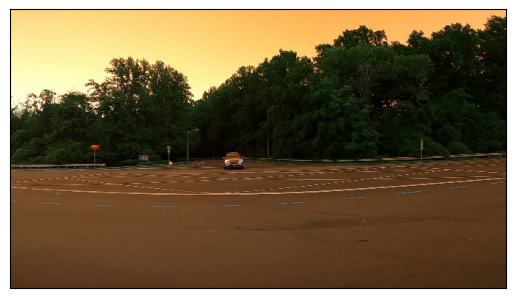

In [6]:

display_image_from_file("vid_4_1000.jpg")

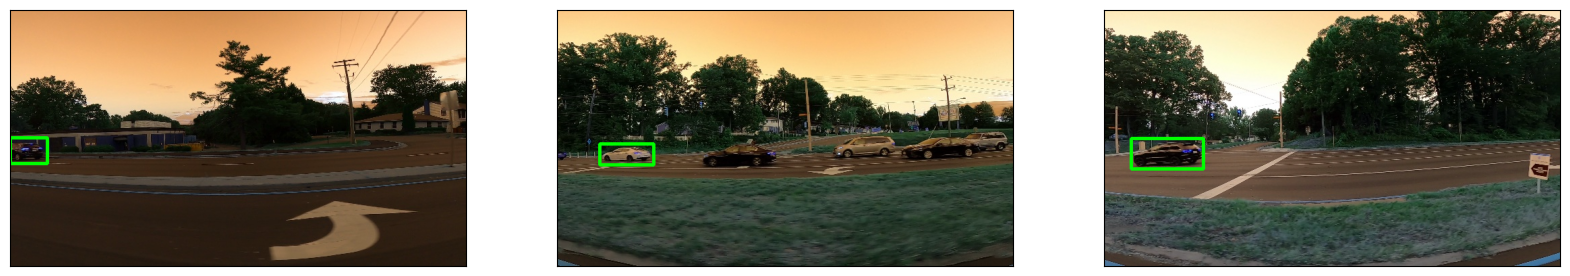

In [7]:
display_grid()

# Model

In [8]:
class CNN_Model(nn.Module):
  def __init__ (self):
    super(CNN_Model, self).__init__()
    self.name = "CNN_Model"
    self.features = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size = 5, stride = 1, padding= 2),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(16, 32, kernel_size = 5, stride = 1, padding= 2),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding= 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding= 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
    )

    self.flatten = nn.Flatten()

    self.fc = nn.Sequential(
        nn.Linear(128 * 23 * 42, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64,16),
        nn.ReLU(),
        nn.Linear(16,4)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.flatten(x)
    x = self.fc(x)
    x = torch.sigmoid(x)

    return x

# Train

In [9]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [10]:
test = pd.read_csv('/kaggle/input/car-object-detection/data/sample_submission.csv')

In [13]:
def evaluate(model, criterion, val_data_path = test_path):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  path = test_path
  model = model.to(device)
  total_loss = 0.0
  total_err = 0.0
  total_epoch = 0

  for i in range(len(test)):
    image, bounds = train.iloc[i]

    og_image = cv2.imread(str(path/image))
    image = cv2.cvtColor(og_image, cv2.COLOR_BGR2RGB)

    image = image.astype(np.float32) / 255.0
    image = np.transpose(image, (2,0,1))

    image = torch.from_numpy(image).float().unsqueeze(0).to(device)

    outputs = model(image)  # shape: [1, 4]
    outputs = outputs.squeeze().detach().cpu().numpy()  # shape: (4,)

    # Denormalize prediction to pixel values
    img_width = og_image.shape[1]
    img_height = og_image.shape[0]

    pred_xmin = int(outputs[0] * img_width)
    pred_ymin = int(outputs[1] * img_height)
    pred_xmax = int(outputs[2] * img_width)
    pred_ymax = int(outputs[3] * img_height)

    pred_coords = [pred_xmin, pred_ymin, pred_xmax, pred_ymax]

    total_err += torch.abs(outputs - pred_coords).mean().item()
    total_loss += loss.item()

    total_epoch += 1


  err = float(total_err) / total_epoch
  loss = float(total_loss) / total_epoch

  return err, loss



In [14]:
def train_func(model, batch_size = 64, learning_rate = 0.01, num_epochs = 50, path = train_path):
  torch.manual_seed(1000)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  model = model.to(device)

  criterion = nn.SmoothL1Loss()
  optimizer = optim.SGD(model.parameters() , lr= learning_rate, momentum=0.9)

  train_err = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_err = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)
  start_time = time.time()

  for epoch in range(num_epochs):
    total_train_loss = 0.0
    total_train_err = 0.0
    total_epoch = 0
    for i in range(len(train)):
      image, xmin, ymin, xmax, ymnax = train.iloc[i]

      image = cv2.imread(str(path/image))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      image = image.astype(np.float32) / 255.0
      image = np.transpose(image, (2,0,1))
      image = torch.from_numpy(image).float().unsqueeze(0).to(device)

      labels = torch.tensor([xmin / 676, ymin / 380, xmax / 676, ymnax / 380]).float().unsqueeze(0).to(device)
      #labels = torch.tensor([xmin, ymin, xmax, ymnax]).float().unsqueeze(0)

      optimizer.zero_grad()

      outputs = model(image)

      loss = criterion(outputs,labels)

      loss.backward()
      optimizer.step()

      total_train_err += torch.abs(outputs - labels).mean().item()
      total_train_loss += loss.item()

      total_epoch += 1

    train_err[epoch] = float(total_train_err) / total_epoch
    train_loss[epoch] = float(total_train_loss) / total_epoch
    #val_err[epoch], val_loss[epoch] = evaluate(model=model, criterion=criterion)
    print(f"Epoch: {epoch}, Train error: {train_err[epoch]}, Train loss: {train_loss[epoch]}")

    # Save the current model (checkpoint) to a file
    model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
    torch.save(model.state_dict(), model_path)

  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

  # Write the train/test loss/err into CSV file for plotting later
  epochs = np.arange(1, num_epochs + 1)
  np.savetxt("{}_train_err.csv".format(model_path), train_err)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_err.csv".format(model_path), val_err)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


In [11]:
model = CNN_Model()

In [24]:
train_func(model, num_epochs=25)

Epoch: 0, Train error: 0.019983611474941734, Train loss: 0.0003950624041171465
Epoch: 1, Train error: 0.017455591455521717, Train loss: 0.0002946715072296133
Epoch: 2, Train error: 0.01627573798554884, Train loss: 0.00025410427092730306
Epoch: 3, Train error: 0.01627950084356355, Train loss: 0.00025578206677123424
Epoch: 4, Train error: 0.01574905888689026, Train loss: 0.00023766392453286296
Epoch: 5, Train error: 0.015347478263289995, Train loss: 0.00023589046511044448
Epoch: 6, Train error: 0.014695746325690982, Train loss: 0.00020500774459871767
Epoch: 7, Train error: 0.013456698156840785, Train loss: 0.00017675429611264124
Epoch: 8, Train error: 0.012626122087764908, Train loss: 0.00015015094529420385
Epoch: 9, Train error: 0.012042504276844187, Train loss: 0.0001391599584384891
Epoch: 10, Train error: 0.011491757540793067, Train loss: 0.0001272579487188212
Epoch: 11, Train error: 0.010847535417218444, Train loss: 0.00011271877864870271
Epoch: 12, Train error: 0.010355572890437825,

# Visualize Model

Predicted (pixels): [8, 189, 80, 249]
Ground truth: [0, 188, 85, 249]


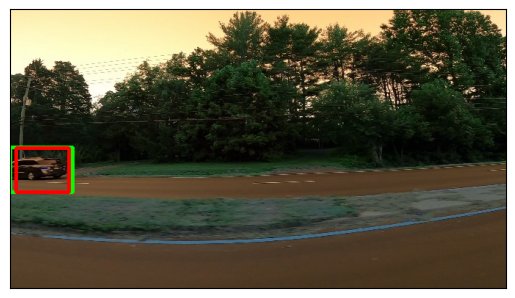

In [25]:
path = train_path
image, xmin, ymin, xmax, ymax = train.iloc[7]

og_image = cv2.imread(str(path/image))
image = cv2.cvtColor(og_image, cv2.COLOR_BGR2RGB)

image = image.astype(np.float32) / 255.0
image = np.transpose(image, (2,0,1))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image = torch.from_numpy(image).float().unsqueeze(0).to(device)

model = model.to(device)
model.eval()

# Run inference
with torch.no_grad():
    outputs = model(image)  # shape: [1, 4]
    outputs = outputs.squeeze().detach().cpu().numpy()  # shape: (4,)

# Denormalize prediction to pixel values
img_width = og_image.shape[1]
img_height = og_image.shape[0]


pred_xmin = int(outputs[0] * img_width)
pred_ymin = int(outputs[1] * img_height)
pred_xmax = int(outputs[2] * img_width)
pred_ymax = int(outputs[3] * img_height)

# Ground truth (unnormalized, already in pixel coords)
gt_coords = [int(xmin), int(ymin), int(xmax), int(ymax)]
pred_coords = [pred_xmin, pred_ymin, pred_xmax, pred_ymax]

print("Predicted (pixels):", pred_coords)
print("Ground truth:", gt_coords)

# Display
display_image(img=og_image, bbox_coords=gt_coords, pred_coords=pred_coords)

Predicted (pixels): [170, 191, 269, 234]


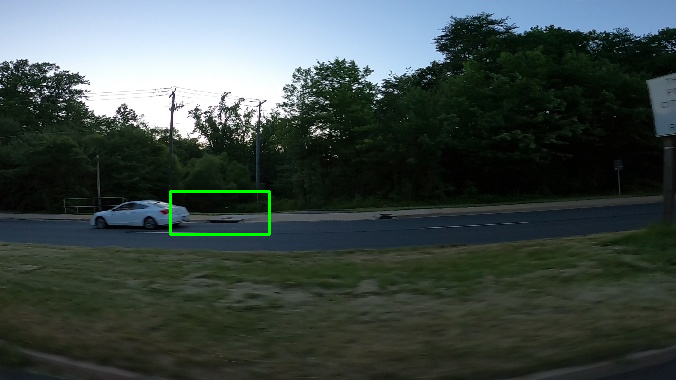

Predicted (pixels): [19, 189, 86, 221]


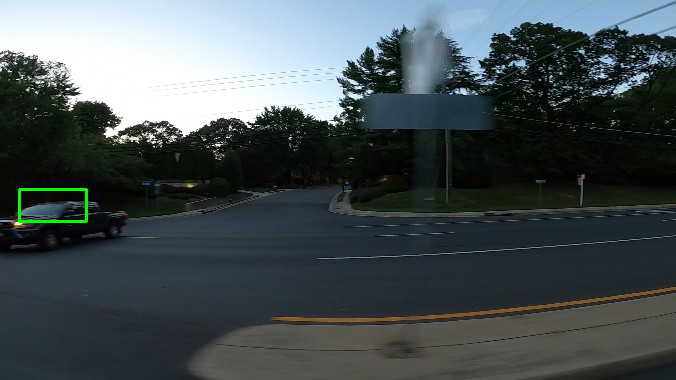

Predicted (pixels): [69, 174, 178, 228]


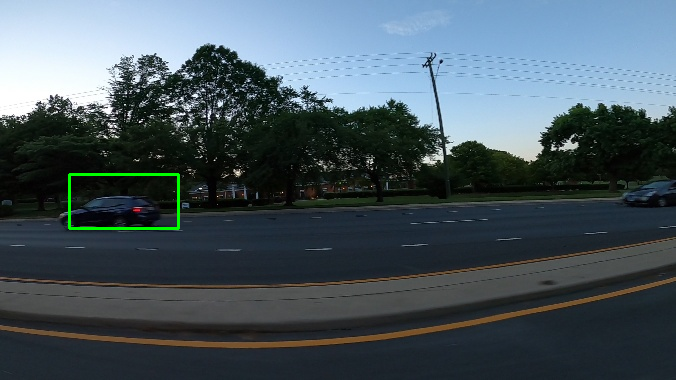

Predicted (pixels): [27, 186, 144, 250]


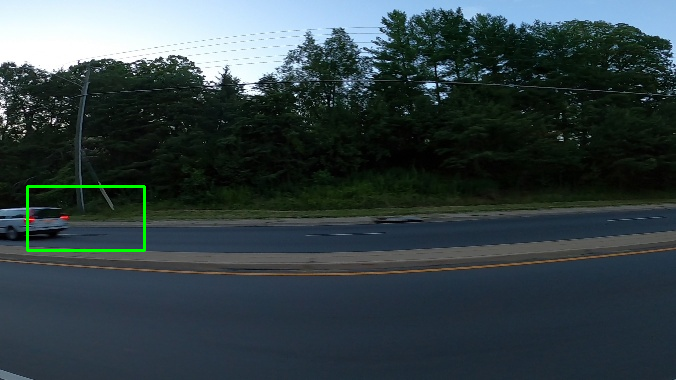

Predicted (pixels): [451, 178, 576, 220]


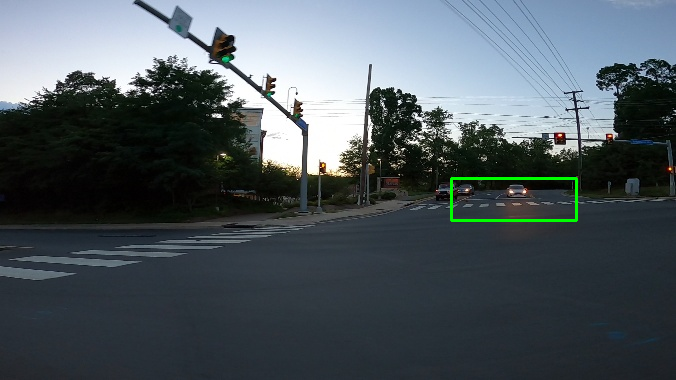

In [28]:
import random
from google.colab.patches import cv2_imshow

path = test_path
test = pd.read_csv('/kaggle/input/car-object-detection/data/sample_submission.csv')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

frames = [random.randint(0, len(test)-1) for _ in range(5)]

for frame in frames:
  image, bounds = test.iloc[frame]

  og_image = cv2.imread(str(path/image))
  image = cv2.cvtColor(og_image, cv2.COLOR_BGR2RGB)

  image = image.astype(np.float32) / 255.0
  image = np.transpose(image, (2,0,1))

  image = torch.from_numpy(image).float().unsqueeze(0).to(device)

  # Run inference
  with torch.no_grad():
      outputs = model(image)  # shape: [1, 4]
      outputs = outputs.squeeze().detach().cpu().numpy()  # shape: (4,)

  # Denormalize prediction to pixel values
  img_width = og_image.shape[1]
  img_height = og_image.shape[0]


  pred_xmin = int(outputs[0] * img_width)
  pred_ymin = int(outputs[1] * img_height)
  pred_xmax = int(outputs[2] * img_width)
  pred_ymax = int(outputs[3] * img_height)

  pred_coords = [pred_xmin, pred_ymin, pred_xmax, pred_ymax]

  print("Predicted (pixels):", pred_coords)

  # Display
  # Draw predicted box on frame
  cv2.rectangle(og_image, (pred_xmin, pred_ymin), (pred_xmax, pred_ymax), (0, 255, 0), 2)

  # Show the frame
  cv2_imshow(og_image)
  time.sleep(0.1)

# Video Test

In [ ]:
cap = cv2.VideoCapture("/content/drive/MyDrive/Colab Notebooks/Car Object Detection Video Test/cars.mp4")

while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    break
  input_image = cv2.resize(frame, (img_width, img_height))
  input_tensor = torch.from_numpy(input_image).permute(2, 0, 1).unsqueeze(0).float().to(device)

  img_width = input_image.shape[1]
  img_height = input_image.shape[0]

  with torch.no_grad():
    outputs = model(input_tensor)  # shape: [1, 4]
    outputs = outputs.squeeze().detach().cpu().numpy()  # shape: (4,)

  pred_xmin = int(outputs[0] * img_width)
  pred_ymin = int(outputs[1] * img_height)
  pred_xmax = int(outputs[2] * img_width)
  pred_ymax = int(outputs[3] * img_height)

  pred_coords = [pred_xmin, pred_ymin, pred_xmax, pred_ymax]

  print("Predicted (pixels):", pred_coords)

  # Draw predicted box on frame
  cv2.rectangle(input_image, (pred_xmin, pred_ymin), (pred_xmax, pred_ymax), (0, 255, 0), 2)

  # Show the frame
  cv2_imshow(input_image)
  time.sleep(0.1)


cap.release()
cv2.destroyAllWindows()